<h1 style = "font-size:3rem;color:darkcyan"> Train Classifier</h1>


In [92]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [93]:
# import dataset
def import_dataset(dataset_path):
    with open(dataset_path, 'r') as f:
        data = json.load(f)
        
    # split data
    
    # split list into different np arrays
    mappings = np.array(data['mappings']) 
    inputs = np.array(data['MFCC'])
    targets = np.array(data['labels'])
    filenames = np.array(data['filenames'])
    
    return mappings, inputs, targets, filenames

In [94]:
mappings, inputs, targets, filenames = import_dataset('data.json')

In [91]:
type(inputs)

numpy.ndarray

In [95]:
# adjusting the input shape for CNN compatibility (from 2D to 3D (excluding # samples))
print('input shape before: {}'.format(inputs.shape))
inputs = inputs[..., np.newaxis] 
print('input shape after: {}'.format(inputs.shape))

input shape before: (27392, 47, 13)
input shape after: (27392, 47, 13, 1)


In [96]:
# splitting data into train, validation, and testing sets
# filenames for misclassification-tracking

def train_validation_test_split(x, y, filenames, test_size = 0.25, val_size = 0.2):
    if (0 < test_size < 1)  and (0 < val_size < 1):
        train_size = 1 - test_size - val_size
        if train_size > 0:

            # train test split
            (
            x_train, x_test, 
            y_train, y_test,
            fn_train, fn_test
            ) = train_test_split(x, y, filenames, test_size = test_size)

            #train validation split
            (
            x_train, x_val, 
            y_train, y_val, 
            fn_train, fn_val
            ) = train_test_split(x_train, y_train, fn_train, test_size = val_size)

            return x_train, x_val, x_test, y_train, y_val, y_test, fn_train, fn_val, fn_test
        else: 
            print('train size is too small, adjust test and validation sizes')
            return
    else:
        print('test and validation size should be between 0 and 1!')
        return

In [97]:
# split data into train, validation and test sets
(
x_train, x_val, x_test,
y_train, y_val, y_test,
fn_train, fn_val, fn_test
) = train_validation_test_split(inputs, targets, filenames, test_size = 0.25, val_size = 0.2)

In [98]:
def build_CNN_model(input_shape, output_len):
    # create model
    model = keras.Sequential()
    
    # 1st CNN layer
    model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu',
                                  input_shape = input_shape,
                                  kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    
    
    # 2nd CNN layer
    model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
   
              
    # 3rd CNN layer
    model.add(keras.layers.Conv2D(32, (2,2), activation = 'relu', input_shape = input_shape, kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'))
              
    # flatten layer & feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(output_len, activation = 'softmax'))
    
    return model
    

In [99]:
# build model
input_shape = [inputs.shape[1], inputs.shape[2], inputs.shape[3]]
model = build_CNN_model(input_shape, len(mappings))

In [100]:
# compile model
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer = optimizer,
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 45, 11, 64)        640       
                                                                 
 batch_normalization_15 (Bat  (None, 45, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 23, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 4, 32)         18464     
                                                                 
 batch_normalization_16 (Bat  (None, 21, 4, 32)        128       
 chNormalization)                                                
                                                      

In [102]:
# train model
history = model.fit(x_train, y_train,
                   validation_data = (x_val, y_val),
                   batch_size = 32, 
                   epochs = 30)

Epoch 1/30


UnimplementedError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Cast' defined at (most recent call last):
    File "C:\Users\helme\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\helme\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\helme\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\helme\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\helme\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\helme\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\helme\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\helme\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\helme\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\helme\AppData\Local\Temp\ipykernel_18764\692836291.py", line 2, in <cell line: 2>
      history = model.fit(x_train, y_train,
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\backend.py", line 5580, in sparse_categorical_crossentropy
      target = cast(target, "int64")
    File "C:\Users\helme\anaconda3\lib\site-packages\keras\backend.py", line 2295, in cast
      return tf.cast(x, dtype)
Node: 'sparse_categorical_crossentropy/Cast'
Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]] [Op:__inference_train_function_86719]

In [16]:
 def plot_training_history(history, figsize = [15,6]):
    
    fig, ax = plt.subplots(2, figsize=figsize)
    
    # create accuracy subplot
    ax[0].plot(history.history['accuracy'], label = 'Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_title('Accuracy Evaluation')
    
    # create error subplot
    ax[1].plot(history.history['loss'], label = 'Training Error')
    ax[1].plot(history.history['val_loss'], label = 'Validation Error')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Error Evaluation')
    
    plt.show()

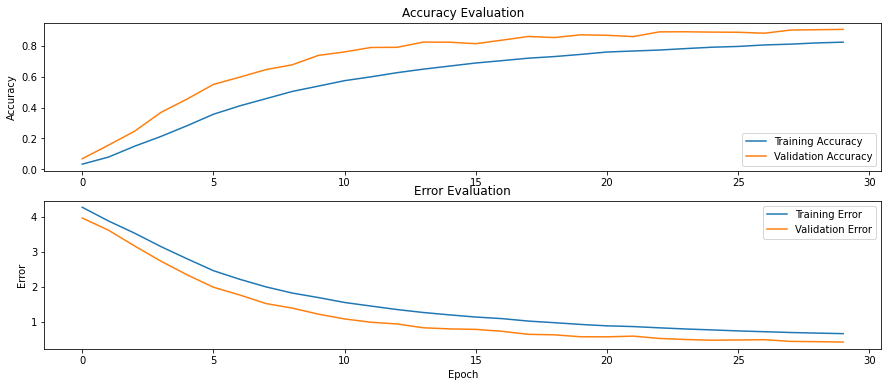

In [17]:
plot_training_history(history)

In [18]:
# test model accuracy:
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose = True)
print('Model loss = {} | model accuracy = {}'.format(test_error, test_accuracy))

214/214 [==============================] - 1s 4ms/step - loss: 0.4173 - accuracy: 0.9044
Model loss = 0.41734978556632996 | model accuracy = 0.9043516516685486


In [19]:
# get predictions
y_pred = model.predict(x_test)
pred_classes = np.argmax(y_pred, axis=1)

214/214 [==============================] - 1s 4ms/step


In [20]:
# visualize confusion matrix

def plot_confusion_matrix(true_target, predicted_target, classes, normalize = None, cmap= 'PuBu', size = [6,6], fontsize=9):
    # get confusion matrix
    labels = np.arange(0,len(classes), 1)
    cm = sklearn.metrics.confusion_matrix(true_target, predicted_target, labels = labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Absolute Confusion Matrix'
        
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)
    
    
    # set labels ticks
    ticks = np.arange(cm.shape[1])
    ax.set(xticks=ticks,
           yticks=ticks,
           xticklabels=classes, 
           yticklabels=classes,
          )
    
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel('True Class', fontsize = fontsize)
    ax.set_xlabel('Predicted Class', fontsize = fontsize)
     
    # style tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    plt.setp(ax.get_yticklabels(), ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    
    # plot text annotation inside each segment
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize = fontsize)

    fig.tight_layout()
    plt.show()

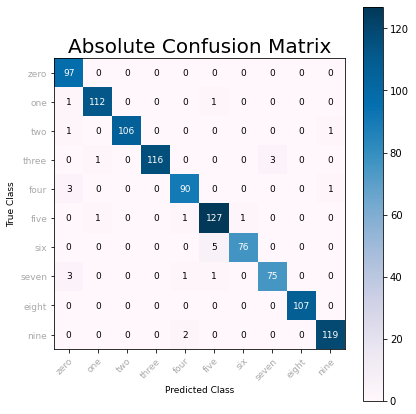

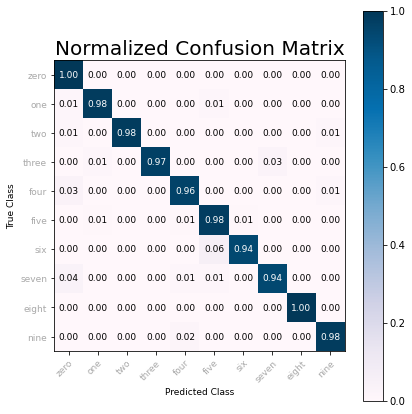

In [46]:
plot_confusion_matrix(y_test, pred_classes, classes = mappings, normalize = False)
plot_confusion_matrix(y_test, pred_classes, classes = mappings, normalize = True)

In [45]:
matches = pred_classes != y_test
print('Number of misclassified audiofiles = {} / {}'.format(np.count_nonzero(matches), len(y_pred)))
print('\nMisclassifed files:')
#displaying names of misclassified files
for i in range(len(y_test)):
    if pred_classes[i] != y_test[i]:
        print('{: <25} {: <10}  classified as {}'.format(fn_test[i], '(' + mappings[y_test[i]] + ')', mappings[pred_classes[i]]))

Number of misclassified audiofiles = 655 / 6848

Misclassifed files:


IndexError: index 49 is out of bounds for axis 0 with size 10